In [34]:
from google.colab import files
uploaded = files.upload()  # Opens file chooser to upload files

Saving test.zip to test.zip


In [35]:
!unzip test.zip

Archive:  test.zip
   creating: test/
   creating: test/Buffalo/
  inflating: test/Buffalo/test_1.png  
  inflating: test/Buffalo/test_10.jpg  
  inflating: test/Buffalo/test_11.jpg  
  inflating: test/Buffalo/test_12.jpg  
  inflating: test/Buffalo/test_13.jpg  
  inflating: test/Buffalo/test_14.jpg  
  inflating: test/Buffalo/test_15.jpg  
  inflating: test/Buffalo/test_16.jpg  
  inflating: test/Buffalo/test_17.jpg  
  inflating: test/Buffalo/test_18.jpg  
  inflating: test/Buffalo/test_19.jpg  
  inflating: test/Buffalo/test_2.jpg  
  inflating: test/Buffalo/test_20.jpg  
  inflating: test/Buffalo/test_21.jpg  
  inflating: test/Buffalo/test_3.jpg  
  inflating: test/Buffalo/test_4.jpg  
  inflating: test/Buffalo/test_5.jpg  
  inflating: test/Buffalo/test_6.jpg  
  inflating: test/Buffalo/test_7.jpg  
  inflating: test/Buffalo/test_8.jpg  
  inflating: test/Buffalo/test_9.jpg  
   creating: test/Cheetah/
  inflating: test/Cheetah/test_22.jpg  
  inflating: test/Cheetah/test_23.jpg

In [4]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
# Define dataset paths
train_dir = '/content/animal_image/train'  # Update with your dataset path
val_dir = '/content/animal_image/valid'      # Update with your dataset path


In [6]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)


In [7]:

# Load pre-trained ResNet-18
model = torchvision.models.resnet18(pretrained=True)

# Modify the final fully connected layer
num_classes = len(train_data.classes)  # Number of animal classes
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.3MB/s]


In [8]:

# Training loop
num_epochs = 30
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate metrics
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/30] - Train Loss: 0.7300, Train Acc: 75.50% - Val Loss: 1.0989, Val Acc: 72.00%
Epoch [2/30] - Train Loss: 0.4068, Train Acc: 89.00% - Val Loss: 2.2684, Val Acc: 61.00%
Epoch [3/30] - Train Loss: 0.5881, Train Acc: 82.00% - Val Loss: 2.8796, Val Acc: 54.00%
Epoch [4/30] - Train Loss: 0.4081, Train Acc: 86.75% - Val Loss: 0.4341, Val Acc: 86.00%
Epoch [5/30] - Train Loss: 0.1813, Train Acc: 93.50% - Val Loss: 0.1525, Val Acc: 95.00%
Epoch [6/30] - Train Loss: 0.0886, Train Acc: 96.25% - Val Loss: 1.3976, Val Acc: 76.00%
Epoch [7/30] - Train Loss: 0.1227, Train Acc: 95.75% - Val Loss: 0.4678, Val Acc: 84.00%
Epoch [8/30] - Train Loss: 0.1333, Train Acc: 96.50% - Val Loss: 0.2347, Val Acc: 90.00%
Epoch [9/30] - Train Loss: 0.0573, Train Acc: 98.75% - Val Loss: 0.3369, Val Acc: 86.00%
Epoch [10/30] - Train Loss: 0.0701, Train Acc: 97.25% - Val Loss: 0.2739, Val Acc: 91.00%
Epoch [11/30] - Train Loss: 0.0541, Train Acc: 98.00% - Val Loss: 0.3892, Val Acc: 82.00%
Epoch [12/30] - Tra

In [12]:
print(val_accuracies)
print(train_accuracies)
print(train_losses)
print(val_losses)

[72.0, 61.0, 54.0, 86.0, 95.0, 76.0, 84.0, 90.0, 86.0, 91.0, 82.0, 84.0, 90.0, 73.0, 90.0, 77.0, 83.0, 80.0, 85.0, 87.0, 92.0, 87.0, 96.0, 95.0, 94.0, 87.0, 84.0, 85.0, 79.0, 88.0]
[75.5, 89.0, 82.0, 86.75, 93.5, 96.25, 95.75, 96.5, 98.75, 97.25, 98.0, 97.0, 97.25, 97.0, 96.5, 95.75, 97.0, 95.75, 95.25, 97.75, 98.75, 99.75, 99.75, 98.5, 98.75, 98.25, 98.5, 97.25, 99.0, 98.5]
[0.7300324141979218, 0.406754187643528, 0.588053150177002, 0.40812596172094345, 0.18125610321760177, 0.08859549075365067, 0.12267879717051983, 0.13333906590938568, 0.05725214026868344, 0.07009310932829976, 0.054108346505090596, 0.1011632078094408, 0.09776675499975682, 0.11915386759676039, 0.13794642116874456, 0.14570360485464334, 0.13213120317086577, 0.12778106565587222, 0.16487751950509846, 0.0655589453689754, 0.03962672227062285, 0.014853899931767955, 0.008459351350320504, 0.04506545293843374, 0.0504393441346474, 0.07038785522338004, 0.10055718707852065, 0.10349879543296993, 0.05957040354609489, 0.047104549473151

In [28]:

# Training loop
num_epochs2 = 10
train_accuracies2, val_accuracies2 = [], []
train_losses2, val_losses2 = [], []

for epoch in range(num_epochs2):
    # Training phase
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses2.append(train_loss / len(train_loader))
    train_accuracies2.append(train_acc)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate metrics
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_losses2.append(val_loss / len(val_loader))
    val_accuracies2.append(val_acc)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs2}] - "
          f"Train Loss: {train_losses2[-1]:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_losses2[-1]:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/10] - Train Loss: 0.0172, Train Acc: 99.75% - Val Loss: 0.3960, Val Acc: 90.00%
Epoch [2/10] - Train Loss: 0.0197, Train Acc: 99.50% - Val Loss: 0.4355, Val Acc: 89.00%
Epoch [3/10] - Train Loss: 0.0094, Train Acc: 99.75% - Val Loss: 0.3046, Val Acc: 89.00%
Epoch [4/10] - Train Loss: 0.0120, Train Acc: 99.75% - Val Loss: 0.2582, Val Acc: 91.00%
Epoch [5/10] - Train Loss: 0.0024, Train Acc: 100.00% - Val Loss: 0.2978, Val Acc: 89.00%
Epoch [6/10] - Train Loss: 0.0045, Train Acc: 100.00% - Val Loss: 0.2727, Val Acc: 94.00%
Epoch [7/10] - Train Loss: 0.0020, Train Acc: 100.00% - Val Loss: 0.2623, Val Acc: 94.00%
Epoch [8/10] - Train Loss: 0.0005, Train Acc: 100.00% - Val Loss: 0.2546, Val Acc: 93.00%
Epoch [9/10] - Train Loss: 0.0010, Train Acc: 100.00% - Val Loss: 0.2343, Val Acc: 94.00%
Epoch [10/10] - Train Loss: 0.0015, Train Acc: 100.00% - Val Loss: 0.2669, Val Acc: 92.00%


In [29]:
train_accuracies.extend(train_accuracies2)
train_losses.extend(train_losses2)
val_accuracies.extend(val_accuracies2)
val_losses.extend(val_losses2)


In [30]:
print(len(val_accuracies))

40


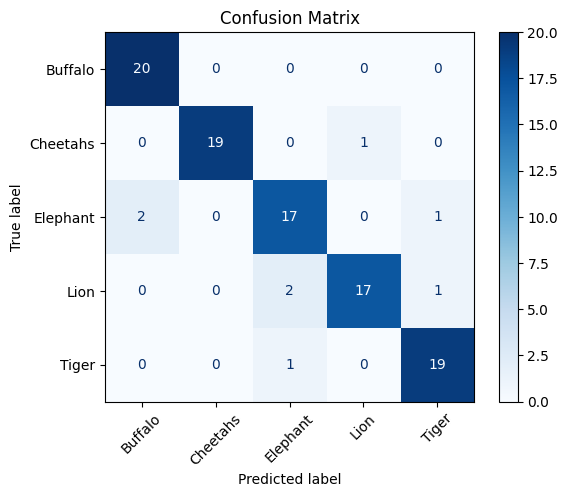

Final Training Accuracy: 100.00%
Final Validation Accuracy: 92.00%


In [31]:

# Evaluate model and plot confusion matrix
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
class_names = train_data.classes
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Print overall accuracy
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")


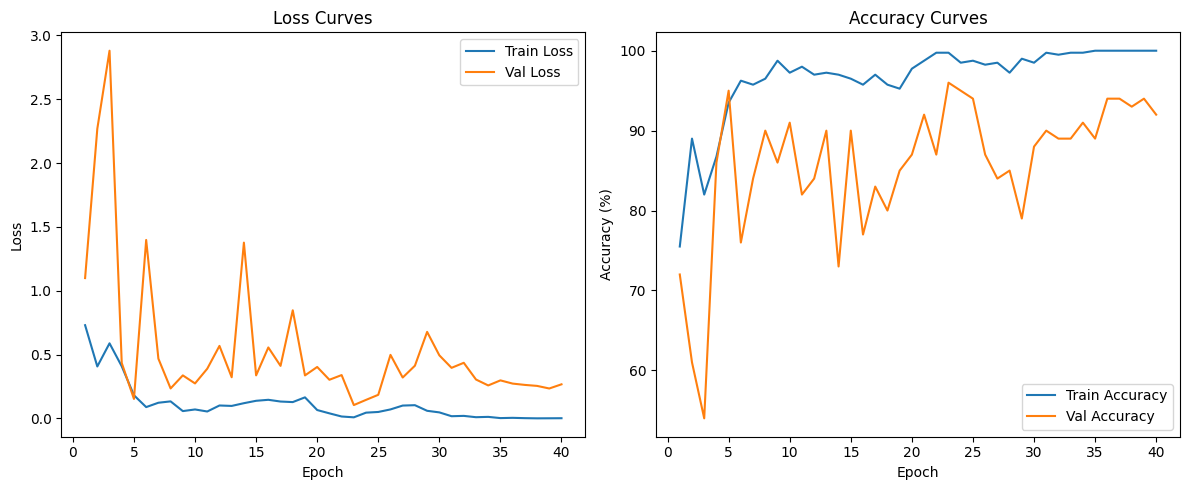

In [32]:
num_epochs=40
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 93.33%

Classification Report:
              precision    recall  f1-score   support

     Buffalo       0.89      0.81      0.85        21
     Cheetah       1.00      1.00      1.00        21
    Elephant       0.95      0.90      0.93        21
        Lion       1.00      1.00      1.00        21
       Tiger       0.83      0.95      0.89        21

    accuracy                           0.93       105
   macro avg       0.94      0.93      0.93       105
weighted avg       0.94      0.93      0.93       105



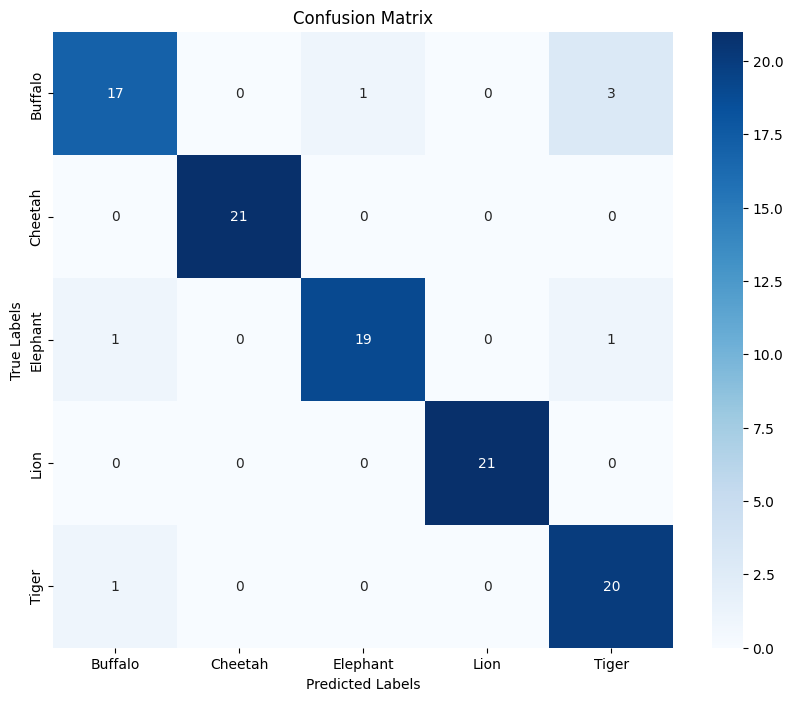

In [41]:
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define the test transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the test dataset
test_dir = '/content/test'  # Update this with your test folder path
test_data = datasets.ImageFolder(
    test_dir,
    transform=test_transform,
    is_valid_file=lambda path: not any(x in path for x in [".ipynb_checkpoints", "other_invalid_folder"])
)
# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

# Load the trained model
model.eval()

# Initialize variables for tracking predictions and ground truth
all_preds = []
all_labels = []

# Perform testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Print the classification report
class_names = test_data.classes
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [42]:
import torch

def save_model(model, path):
    """
    Saves the PyTorch model to the specified path.

    Args:
    - model (torch.nn.Module): The trained model to save.
    - path (str): The file path to save the model.
    """
    try:
        torch.save(model.state_dict(), path)
        print(f"Model successfully saved to {path}")
    except Exception as e:
        print(f"Error saving model: {e}")

# Example usage:
model_save_path = '/content/trained_model.pth'  # Update with your desired save path
save_model(model, model_save_path)


Model successfully saved to /content/trained_model.pth
